# Supervised Shallow Machine Learning: Random Forest Regressor

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; padding: 10px; margin: 10px 0; text-align: center;">
    
    Random forest regressor is an *ensemble* learning method that builds multiple decision trees and aggregates 
    their continuous outputs to capture complex nonlinear relationships in data.
<div>

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import shap

# Data Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Load CSV files containing variables -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match relevant CSV files
file_pattern = "cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_*.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    var_name = file.split("_")[-1].split(".")[0]  # Extract variable name from filename
    df_dict[var_name] = pd.read_csv(file, comment='#')

# Ensure SSH is processed correctly (dates + renaming 'zos' to 'SSH')
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['dates'] = SSH['dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['dates'] = pd.to_datetime(SSH['dates'])
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})  # Rename 'zos' to 'SSH'
    SSH = SSH[['dates', 'SSH']]  # Keep 'dates' and SSH variable

# Mapping of expected variables to their corresponding column names in CSVs
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Merge all datasets dynamically
df = SSH.copy() if SSH is not None else pd.DataFrame()

for key, col in data_vars.items():
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key  # Ensure velocity data is accessed correctly
    if dataset_key in df_dict:
        df[key] = df_dict[dataset_key][col].values  # Assign values from each dataset

# Print the first few rows to verify the result
print(df.head())

       dates       SSH        SST        SSS       Vuo       Vvo        MLD
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428
2 1993-01-03 -0.137028  25.314096  36.233101 -0.120243  0.763573  63.325909
3 1993-01-04 -0.170598  25.159552  36.242256  0.032960  0.979034  50.813320
4 1993-01-05 -0.165105  25.166143  36.240730  0.083010  1.031526  49.897766


### Set the `predictor` and `target` variables (X, y)

In [3]:
predictors = ['SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors].values 
y = df['SST'].values      # Target variable
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 5) (10408,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [4]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Random Forest Regressor
<div>

In [5]:
# Initialize and Train Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators = 100,  # Number of trees in the forest
    max_depth = None,    # Trees grow until all leaves are pure (default behavior)
    random_state = 42,   # Ensures reproducibility
    n_jobs = -1)

In [6]:
#Fit the model on the training set
rf_model.fit(X_train, y_train)

# Predict SST on the test dataset
y_pred = rf_model.predict(X_test)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Metrics for Random Forest Model: `R2` and `RMSE`

In [7]:
# R², MSE, RMSE Random Forest:
r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared = False)
rmse= np.sqrt(mse)

# Print output
print(f"RandomForest Regress R²  : {r2:.2f}" )
print(f"RandomForest Regress MSE : {mse:.2f}")
print(f"RandomForest Regress RMSE: {rmse:.2f}")

RandomForest Regress R²  : 0.72
RandomForest Regress MSE : 1.06
RandomForest Regress RMSE: 1.03


### The R² values are similar but that's a better error! Do we see the same feature contributions now that we're able to handle more `complexity`?

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Feature Importance
</div>

In [8]:
# Using SHAP to explain our model predications
explainer = shap.TreeExplainer(rf_model )    # Explain model predictions
shap_vals = explainer.shap_values(X_test)    # Compute SHAP values for test data

# Compare Feature Importances from RF
rf_importance = pd.Series(rf_model.feature_importances_, index=predictors)
# Create DataFrame (df) to hold the feature names and their RF importance:
rf_df = pd.DataFrame({
    "Variables": predictors,
    "RF Importance": rf_importance})

# Sort rf_df so most important variables are at the top (descending order)
rf_df.sort_values(by = "RF Importance", ascending = False, inplace = True)
print(rf_df)

    Variables  RF Importance
SSH       SSH       0.391379
MLD       MLD       0.349466
SSS       SSS       0.129765
Vvo       Vvo       0.072031
Vuo       Vuo       0.057358


In [9]:
# Compute the mean absolute SHAP values for each feature
# This provides a robust measure of feature importance
shap_importance = np.abs(shap_vals).mean(axis = 0)

# Create a DataFrame to hold the feature names and their SHAP importance
shap_df = pd.DataFrame({
    "Variables": predictors,
    "Mean Absolute SHAP": shap_importance})

# Sort the DataFrame so that the most important features are at the top
shap_df.sort_values(by="Mean Absolute SHAP", ascending=False, inplace=True)
print(shap_df)

  Variables  Mean Absolute SHAP
0       SSH            0.931536
4       MLD            0.930361
1       SSS            0.344264
3       Vvo            0.106811
2       Vuo            0.056187


In [10]:
# For plotting SHAP:
# Use the diverging "Spectral" palette for colormap:
cmap = sns.color_palette("Spectral", as_cmap = True)

# Compute normalized ranking for each feature (btwn 0 - 1)
# Note -- shap_df values used to determine relative order:
norm_ranks = shap_df["Mean Absolute SHAP"].rank(pct = True)

# Map each normalized rank to a colour via colourmap:
colors = norm_ranks.apply(lambda x: cmap(x)).tolist()

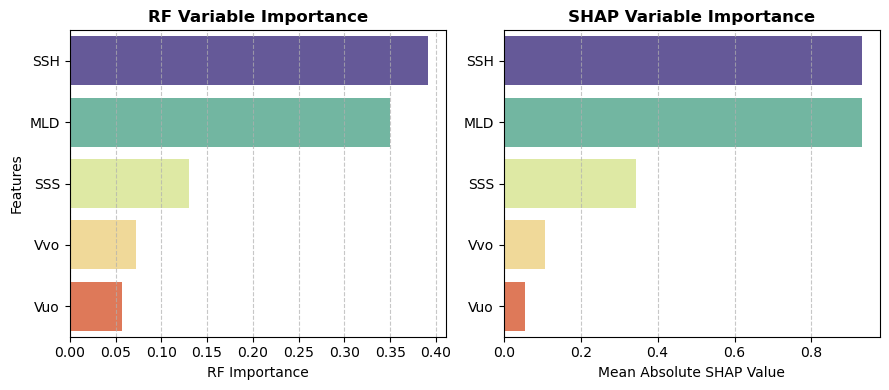

In [11]:
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# ----- Plot RF Feature Importance -----
sns.barplot(data = rf_df, x = "RF Importance", y = "Variables", ax = axes[0],
    palette = colors)
axes[0].set_title( "RF Variable Importance", fontweight='bold')
axes[0].set_xlabel("RF Importance", fontsize = 10)
axes[0].set_ylabel("Features", fontsize = 10)
axes[0].grid(axis = 'x', linestyle = '--', alpha = 0.7)

# ----- Plot SHAP Feature Importance -----
sns.barplot(data = shap_df, x = "Mean Absolute SHAP", y = "Variables", ax=axes[1],
    palette = colors)
axes[1].set_title( "SHAP Variable Importance", fontweight ='bold')
axes[1].set_xlabel("Mean Absolute SHAP Value", fontsize = 10)
axes[1].set_ylabel("")  # Remove redundant ylabel on the right plot
axes[1].grid(axis = 'x', linestyle = '--', alpha = 0.7)

# Show plots
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.em; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    While the ranking is similar, the scales differ because the two methods measure importance in different ways:
    
    ⦾ Random Forest Feature Importance 
       - Calculated based on the reduction in impurity (e.g. the MSE) that each feature provides when used for splits.
       - Normalized (0 - 1), so they represent the relative importance of features in splitting decisions.
       - Rankings are more about the model's inner workings:
       - i.e.: how frequently and effectively features are used to split nodes and reduce error during model training.
        
    ⦾ SHAP Mean Absolute Values
       - Computed per sample as the contribution each feature makes to the model’s prediction, then averaged across all samples.
       - Values are in the same units as the output variable (SST), and are not normalised in the same way as RF.
       - More about the actual impact of feature values:
       - i.e.: how much each feature’s actual value contributed to the prediction (game theory foundation).
<div>

In [ ]:
# Bootstrapping for permutation importance uncertainty:
n_bootstr = 50        # Reduced for faster computation
n_repeats = 5         # Fewer repeats in permutation importance
rng = np.random.RandomState(42)
boot_importances = {feature: [] for feature in predictors}

for i in range(n_bootstr):
    # Bootstrap resample the training data
    indices = rng.choice(np.arange(len(X_train)), size = len(X_train), replace = True)
    X_boot = X_train[indices]
    y_boot = y_train[indices]
    
    # Train model on bootstrap sample
    rf_boot = RandomForestRegressor(n_estimators = 100, max_depth = None, 
                                    random_state = 42, n_jobs = -1)
    rf_boot.fit(X_boot, y_boot)
    
    # Compute permutation importance on fixed test set (use parallel processing if possible)
    perm_importance = permutation_importance(rf_boot, X_test, y_test, n_repeats = n_repeats, 
                                             random_state = 42, n_jobs = -1)
    
    # Save mean importance for features (vars)
    for idx, feature in enumerate(predictors):
        boot_importances[feature].append(perm_importance.importances_mean[idx])


In [ ]:
print('Feature Mean Importance')
print()
# Summarize importances with 95% confidence intervals
importance_summary = {}
for feature in predictors:
    mean_importance = np.mean(boot_importances[feature])
    ci_lower = np.percentile(boot_importances[feature], 2.5 )
    ci_upper = np.percentile(boot_importances[feature], 97.5)
    importance_summary[feature] = (mean_importance, ci_lower, ci_upper)
    # print output in the loop over features
    print(f"{feature} = {mean_importance:.2f}\n   95% CI = ({ci_lower:.2f},{ci_upper:.2f})")
    print()